In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import data_processing 
import numpy as np
from sklearn.inspection import partial_dependence

from sklearn.inspection import PartialDependenceDisplay
import shap
from sklearn.inspection import permutation_importance
import importlib
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
import models

import pickle
import plot_helper as ph


In [3]:
x_train, x_test, y_train, y_test = data_processing.data_selected_features()

In [4]:
### SHAP
def get_shap_values(model, x_train, x_test):
    explainer = shap.KernelExplainer(model.predict,x_train)
    shap_values = explainer.shap_values(x_test)
    return shap_values


In [5]:
def get_random_feature(x_train, x_test, distributions=None, split_column= None, scaling = 0.01):
    if distributions ==  None:
        return  0, 0
    
    elif split_column ==  "":
        return  distributions[0], distributions[1]
    else:
        return x_train.copy()[split_column] + distributions[0] * scaling, x_test.copy()[split_column] + distributions[1] * scaling

        

In [70]:
weibull = (np.random.weibull(1.5,  size=x_train.shape[0]),np.random.weibull(1.5,  size=x_test.shape[0]))
weibull[0].mean(0)

0.8938820316758074

In [209]:
importlib.reload(data_processing)
# beta 
normal = (np.random.normal(0,1,  size=x_train.shape[0]), np.random.normal(0,1,  size=x_test.shape[0]))
weibull = (np.random.weibull(15,  size=x_train.shape[0]),np.random.weibull(15,  size=x_test.shape[0]))


distributions = [None,normal, weibull]
distributions_names = ["Baseline", "Normaldistribution", "Weibulldistribution"] #,, 
sharp_results = {}
sharp_results_unnormal = {}
ebm_results = {}
ebm_results_unnormal = {}
pfi_results = {}
pfi_results_unnormal = {}
split_column = ["", "MOI", "AM"] #, "MOI +, "AM"
scaling = [0.01]  #,2,3,4,4,5 #0.05, , 0.1, 1
number_features = 15
replacing = [True, False] #, False , False

for split in split_column:
    
    for names, dis in zip(distributions_names, distributions):
        for replace_t in replacing:
            for scale in scaling:
                x_train_copy, x_test_copy = x_train.copy(), x_test.copy()
                if names == "Weibulldistribution":
                    x_train_copy["Random"] , x_test_copy["Random"] = get_random_feature(x_train_copy, x_test_copy, dis, scaling=scale, split_column=split)
                else:
                    x_train_copy["Random"] , x_test_copy["Random"] = get_random_feature(x_train_copy, x_test_copy, dis, scaling=1, split_column=split)
                if replace_t:
                    is_replacing = "isReplacing"
                        
                    if split != "":
                    
                        x_train_copy[split] = 0
                        x_test_copy[split] = 0
                    
                else:
                    is_replacing = "isNotReplacing"
                
                nn = models.nn_model()
                nn.fit(x_train_copy, y_train)
                y_predict = nn.predict(x_test_copy)
                acc = accuracy_score(y_test, y_predict)
                print(f"Accuracy {acc} of {names}{split} {scale} {is_replacing} of NN")
                s = get_shap_values(nn, x_train_copy, x_test_copy.iloc[0:number_features]).mean(axis=0)
                sharp_results_unnormal[f"{names}{split}{scale}{is_replacing}"] = s
                shap_values = data_processing.normalize_data(abs(s))    
                print(shap_values)
                sharp_results[f"{names}{split}{scale}{is_replacing}"] = shap_values
                #print(permutation_importance(nn, x_test_copy, y_test, n_repeats=50))
                #print(x_test_copy)
                #print(y_test)
                print(permutation_importance(nn, x_test_copy, y_test, n_repeats=100)["importances_mean"])
                pfi_results[f"{names}{split}{scale}{is_replacing}"] = data_processing.normalize_data(permutation_importance(nn, x_test_copy, y_test, n_repeats=10)["importances_mean"])
                
                pfi_results_unnormal[f"{names}{split}{scale}{is_replacing}"] = permutation_importance(nn, x_test_copy, y_test, n_repeats=10)["importances_mean"]
                ebm = ExplainableBoostingClassifier().fit(x_train_copy, y_train)
                y_predict = ebm.predict(x_test_copy)
                acc = accuracy_score(y_test, y_predict)
                print(f"Accuracy {acc} of {names}{split}{scale}{is_replacing} of ebm")
                ebm_values = data_processing.normalize_data(ebm.term_importances()[0:len(x_train_copy.columns)])
                print(ebm.term_importances()[0:len(x_train.columns)])
                ebm_results_unnormal[f"{names}{split}{scale}{is_replacing}"] = ebm.term_importances()[0:len(x_train.columns)]
                ebm_results[f"{names}{split}{scale}{is_replacing}"] = ebm_values
 
res = {"sharp_results": sharp_results, "sharp_results_unnormal": sharp_results_unnormal, "ebm_results": ebm_results, "ebm_results_unnormal": ebm_results_unnormal, "pfi_results": pfi_results, "pfi_results_unnormal": pfi_results_unnormal}       

with open( f"res/results{number_features}2layer.p", "wb" ) as f:
	pickle.dump(res, f)

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.8411513859275054 of Baseline 0.01 isReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

/home/robin/uu/hcml/HCML_Project/data_processing.py:46: RuntimeWarning: invalid value encountered in double_scalars
  ebm_values.append((v-min_ebm)/(max_ebm-min_ebm))


[nan, nan, nan, nan, nan]
[0. 0. 0. 0. 0.]


/home/robin/uu/hcml/HCML_Project/data_processing.py:46: RuntimeWarning: invalid value encountered in double_scalars
  ebm_values.append((v-min_ebm)/(max_ebm-min_ebm))


Accuracy 0.9968017057569296 of Baseline0.01isReplacing of ebm
[7.79264071 4.35723929 3.53674934 0.36421049]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.9925373134328358 of Baseline 0.01 isNotReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

[1.0, 0.4231024074210399, 0.01588382536994705, 0.005613634690422401, 0.0]
[ 0.25610874  0.24522388  0.00662047 -0.00268657  0.        ]
Accuracy 0.9968017057569296 of Baseline0.01isNotReplacing of ebm
[7.79264071 4.35723929 3.53674934 0.36421049]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.9946695095948828 of Normaldistribution 0.01 isReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

[1.0, 0.4184576415338522, 0.017984321266130716, 0.0, 0.007118293088784326]
[ 0.25697228  0.24872068  0.0124307  -0.00157783  0.00079957]
Accuracy 0.9957356076759062 of Normaldistribution0.01isReplacing of ebm
[6.49074297 3.6339388  2.92520837 0.19681671]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.9893390191897654 of Normaldistribution 0.01 isNotReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

[1.0, 0.4050815519855551, 0.019013313000112827, 0.0, 0.004276987528374377]
[ 0.25689765  0.24708955  0.00697228 -0.0048081   0.00074627]
Accuracy 0.9957356076759062 of Normaldistribution0.01isNotReplacing of ebm
[6.49074297 3.6339388  2.92520837 0.19681671]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.9925373134328358 of Weibulldistribution 0.01 isReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

[1.0, 0.4036456473612785, 0.018862029565092194, 0.0022762979361564935, 0.0]
[ 0.25858209  0.24428571  0.01399787 -0.00415778 -0.00109808]
Accuracy 0.9968017057569296 of Weibulldistribution0.01isReplacing of ebm
[7.07939719 3.96475988 3.20194497 0.27155656]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.9936034115138592 of Weibulldistribution 0.01 isNotReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

[1.0, 0.41843847464479517, 0.015937247314311984, 0.004629562781564043, 0.0]
[ 0.26006397  0.25313433  0.00847548 -0.00208955  0.00051173]
Accuracy 0.9968017057569296 of Weibulldistribution0.01isNotReplacing of ebm
[7.07939719 3.96475988 3.20194497 0.27155656]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.8432835820895522 of BaselineMOI 0.01 isReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

[0.0, 0.2620515695067265, 1.0, 0.2839125560538091, 0.0]
[0.         0.0025693  0.00189765 0.00352878 0.        ]
Accuracy 0.8390191897654584 of BaselineMOI0.01isReplacing of ebm
[3.96508223e-18 1.54592000e+00 1.48499625e+00 1.85288453e-01]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.8411513859275054 of BaselineMOI 0.01 isNotReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

/home/robin/uu/hcml/HCML_Project/data_processing.py:46: RuntimeWarning: invalid value encountered in double_scalars
  ebm_values.append((v-min_ebm)/(max_ebm-min_ebm))


[nan, nan, nan, nan, nan]
[0. 0. 0. 0. 0.]


/home/robin/uu/hcml/HCML_Project/data_processing.py:46: RuntimeWarning: invalid value encountered in double_scalars
  ebm_values.append((v-min_ebm)/(max_ebm-min_ebm))


Accuracy 0.9968017057569296 of BaselineMOI0.01isNotReplacing of ebm
[7.79264071 4.35723929 3.53674934 0.36421049]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.8827292110874201 of NormaldistributionMOI 0.01 isReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

[0.0, 1.0, 0.11933483652762203, 0.05704622322435089, 0.8093010146561443]
[0.         0.14405117 0.00207889 0.00318763 0.1134968 ]
Accuracy 0.8859275053304904 of NormaldistributionMOI0.01isReplacing of ebm
[7.93016446e-18 1.71065209e+00 1.55028624e+00 1.50663828e-01]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.9925373134328358 of NormaldistributionMOI 0.01 isNotReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

[1.0, 0.4093236269435815, 0.02185051095865744, 0.0, 0.013639172445531636]
[ 0.25591684  0.24195096  0.0098081  -0.00251599  0.00028785]
Accuracy 0.9957356076759062 of NormaldistributionMOI0.01isNotReplacing of ebm
[6.52483777 3.73046892 3.02482166 0.20377423]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.9914712153518124 of WeibulldistributionMOI 0.01 isReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

[0.0, 0.4050348412402254, 0.016079904891657323, 0.0024037418537442177, 1.0]
[ 0.          0.25095949  0.01408316 -0.00036247  0.25911514]
Accuracy 0.9968017057569296 of WeibulldistributionMOI0.01isReplacing of ebm
[7.93016446e-18 4.71944638e+00 3.19695440e+00 3.56255819e-01]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.9925373134328358 of WeibulldistributionMOI 0.01 isNotReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

[0.8931142591732473, 0.5838945657222454, 0.038512153584143616, 0.0, 1.0]
[0.08869936 0.24601279 0.01633262 0.0004371  0.09528785]
Accuracy 0.9968017057569296 of WeibulldistributionMOI0.01isNotReplacing of ebm
[4.05423049 4.42435774 3.4272872  0.32671743]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.9925373134328358 of BaselineAM 0.01 isReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

[1.0, 0.0, 0.42439096576089824, 0.0028116387044255925, 0.0]
[ 0.2565565   0.          0.25506397 -0.0021855   0.        ]
Accuracy 0.9968017057569296 of BaselineAM0.01isReplacing of ebm
[7.82675725e+00 3.96508223e-18 7.83946810e+00 3.78609232e-01]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.9946695095948828 of BaselineAM 0.01 isNotReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

[1.0, 0.41138327868551217, 0.017073999577512006, 0.0005786239770760878, 0.0]
[ 0.25817697  0.24384861  0.01794243 -0.00118337  0.        ]
Accuracy 0.9968017057569296 of BaselineAM0.01isNotReplacing of ebm
[7.79264071 4.35723929 3.53674934 0.36421049]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.9957356076759062 of NormaldistributionAM 0.01 isReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

[1.0, 0.0, 0.4217516282792985, 0.001964850998800009, 0.007713859476768]
[0.25986141 0.         0.26490405 0.00081023 0.00529851]
Accuracy 0.9936034115138592 of NormaldistributionAM0.01isReplacing of ebm
[6.63106532e+00 3.96508223e-18 6.50648995e+00 2.21338046e-01]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.9936034115138592 of NormaldistributionAM 0.01 isNotReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

[1.0, 0.4030750070165579, 0.017295818130787864, 0.0039292730844786156, 0.0]
[ 0.25845416  0.25448827  0.0128145  -0.00044776  0.00343284]
Accuracy 0.9946695095948828 of NormaldistributionAM0.01isNotReplacing of ebm
[6.78475317 3.77738523 3.02180822 0.2250627 ]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.9936034115138592 of WeibulldistributionAM 0.01 isReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

[1.0, 0.0, 0.010384035800720802, 0.004520754372346422, 0.42687793963194576]
[ 0.25581023  0.          0.00663113 -0.00160981  0.24881663]
Accuracy 0.9946695095948828 of WeibulldistributionAM0.01isReplacing of ebm
[7.67034703 0.         3.15931912 0.42736   ]


Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy 0.9957356076759062 of WeibulldistributionAM 0.01 isNotReplacing of NN


  0%|          | 0/15 [00:00<?, ?it/s]

[1.0, 0.17709996868639313, 0.020424299358070015, 0.0, 0.16838108658211878]
[ 0.26061834  0.09832623  0.00479744 -0.00109808  0.09628998]
Accuracy 0.9946695095948828 of WeibulldistributionAM0.01isNotReplacing of ebm
[6.99504017 2.20142834 1.97186593 0.30385529]


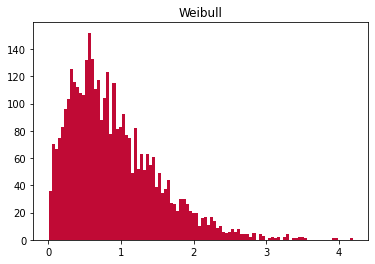

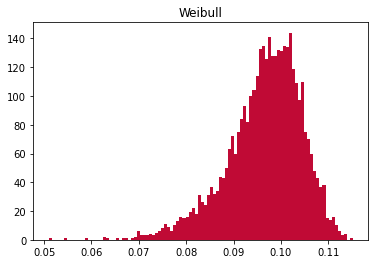

In [208]:
d = np.random.weibull(1.5,  size=x_train.shape[0])
ph.plot_distribution(d, "Weibull")
d = np.random.weibull(15,  size=x_train.shape[0])

d = d * 0.1
ph.plot_distribution(d, "Weibull")


In [190]:
for name, dist in zip(distributions_names, distributions):
    ph.plot_distribution(dist[0], name)

TypeError: 'NoneType' object is not subscriptable

In [56]:
res["sharp_results"]["WeibulldistributionMOI0.01isNotReplacing"]


[1.0, 0.7092843543509894, 0.09980960913875976, 0.0, 0.5879717773546865]

In [ ]:
x_train

,MOI,AM,EDKM,Eccentricity,Random
2349,-0.661600,-0.162578,-0.290351,-0.915936,0
3038,-0.683760,0.045884,-0.386654,1.044756,0
794,-0.605223,-1.100654,0.693882,-0.361054,0
989,0.854746,-0.371039,-0.163398,-0.295951,0
3865,1.050608,-0.232065,-0.251866,-1.037511,0
...,...,...,...,...,...
3664,-0.688332,0.289089,-0.470039,2.449910,0
2880,0.212160,0.601781,-0.544419,-0.450122,0
4675,-0.847108,1.400884,-0.639032,1.360010,0
1001,-0.858094,1.053448,-0.609659,-1.073023,0


In [ ]:
x_test_copy

,MOI,AM,EDKM,Eccentricity,Random
2193,0,1.157679,-0.619929,-0.696176,-0.592478
4596,0,1.088192,-0.613242,-0.997236,-0.660698
3931,0,0.567038,-0.537593,-0.723997,-0.338082
3615,0,-1.795526,2.785020,1.370671,-0.360760
2245,0,0.783143,-0.575366,-1.502642,-0.412312
...,...,...,...,...,...
4514,0,-0.127834,-0.308304,-0.779459,1.052179
2354,0,-1.517577,1.714358,-0.595041,0.960834
2359,0,1.366140,-0.636665,-0.025538,-0.812175
1275,0,-0.371039,-0.163398,0.648788,1.357062


In [8]:
df = pd.DataFrame(res["sharp_results"])
df

ValueError: All arrays must be of the same length

In [119]:
print(res["sharp_results"].keys())
print(res["sharp_results"])
print(res["pfi_results"]["Normaldistribution1isNotReplacing" ])

dict_keys(['Baseline1isNotReplacing', 'Normaldistribution1isNotReplacing', 'Weibulldistribution1isNotReplacing'])
{'Baseline1isNotReplacing': [1.0, 0.3138544348233078, 0.02206880411888518, 0.007395272642172462, 0.0], 'Normaldistribution1isNotReplacing': [1.0, 0.3102769365850152, 0.020371548372067973, 0.0008735463293135478, 0.0], 'Weibulldistribution1isNotReplacing': [1.0, 0.3442336042634034, 0.01701524934238354, 0.0024964458494615947, 0.0]}
[1.0, 0.9761415055532703, 0.04730563554092967, 0.0, 0.02632661456190874]


In [115]:
res["pfi_results"].keys()

dict_keys(['Baseline1isNotReplacing', 'Normaldistribution1isNotReplacing', 'Weibulldistribution1isNotReplacing'])

In [186]:
experiments=["Baseline", "Normaldistribution", "Weibulldistribution"]
c= x_train.columns.tolist() + ["Random"]
ph.plot_bar_per_scale(res["pfi_results"], c,experiments=["Baseline1isNotReplacing", "Normaldistribution1isNotReplacing", "Weibulldistribution1isNotReplacing"], experiments_names=experiments, header="PFI")
ph.plot_bar_per_scale(res["sharp_results"],c,experiments=["Baseline1isNotReplacing", "Normaldistribution1isNotReplacing", "Weibulldistribution1isNotReplacing"], experiments_names=experiments, header="SHAP")
ph.plot_bar_per_scale(res["ebm_results"], c,experiments=["Baseline1isNotReplacing", "Normaldistribution1isNotReplacing", "Weibulldistribution1isNotReplacing"], experiments_names=experiments, header="EBM")

KeyError: 'Baseline1isNotReplacing'

In [144]:
x_train_copy

,MOI,AM,EDKM,Eccentricity,Random
3984,0,-0.435064,-0.098886,1.856115,1.768283
2453,0,-0.992280,0.369710,1.471854,-0.202059
3833,0,-0.678846,0.064749,-0.320886,-0.566660
4633,0,0.296282,-0.365517,0.384051,0.343755
3457,0,0.574890,-0.415918,0.020139,-2.620570
...,...,...,...,...,...
3073,0,0.714195,-0.434954,-0.707030,-0.560266
1369,0,-0.191282,-0.217428,-1.395766,-1.884848
2250,0,1.166933,-0.477348,-1.586133,-0.576523
1519,0,-0.260934,-0.187362,-0.450465,0.813488


In [154]:
res["sharp_results"]

{'NormaldistributionMOI0isReplacing': [0.0,
  0.5030638466100009,
  0.02708045068195236,
  0.0005930025696783671,
  1.0],
 'NormaldistributionMOI1isReplacing': [0.0,
  0.35577098957380565,
  0.027620267056886277,
  0.1885860618254978,
  1.0],
 'NormaldistributionMOI2isReplacing': [nan, nan, nan, nan, nan],
 'NormaldistributionMOI3isReplacing': [0.0,
  0.4828571428571418,
  0.2542857142857133,
  0.32571428571428523,
  1.0],
 'NormaldistributionMOI4isReplacing': [nan, nan, nan, nan, nan],
 'NormaldistributionMOI5isReplacing': [nan, nan, nan, nan, nan],
 'NormaldistributionMOI6isReplacing': [nan, nan, nan, nan, nan],
 'NormaldistributionMOI7isReplacing': [nan, nan, nan, nan, nan],
 'NormaldistributionMOI8isReplacing': [nan, nan, nan, nan, nan],
 'NormaldistributionMOI9isReplacing': [nan, nan, nan, nan, nan]}

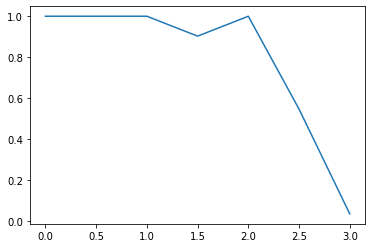

In [170]:
import matplotlib.pyplot as plt
moi_scale_values = []
for scale in scaling:
    moi_scale_values.append(res["sharp_results"][f"NormaldistributionMOI{scale}isReplacing"][4]) 
#
# plt.plot(scaling, moi_scale_values)    
plt.plot(scaling, moi_scale_values )

In [211]:
print(res["pfi_results"].keys())

dict_keys(['Baseline0.01isReplacing', 'Baseline0.01isNotReplacing', 'Normaldistribution0.01isReplacing', 'Normaldistribution0.01isNotReplacing', 'Weibulldistribution0.01isReplacing', 'Weibulldistribution0.01isNotReplacing', 'BaselineMOI0.01isReplacing', 'BaselineMOI0.01isNotReplacing', 'NormaldistributionMOI0.01isReplacing', 'NormaldistributionMOI0.01isNotReplacing', 'WeibulldistributionMOI0.01isReplacing', 'WeibulldistributionMOI0.01isNotReplacing', 'BaselineAM0.01isReplacing', 'BaselineAM0.01isNotReplacing', 'NormaldistributionAM0.01isReplacing', 'NormaldistributionAM0.01isNotReplacing', 'WeibulldistributionAM0.01isReplacing', 'WeibulldistributionAM0.01isNotReplacing'])


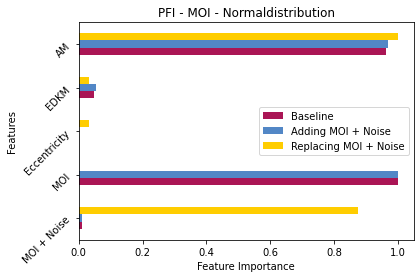

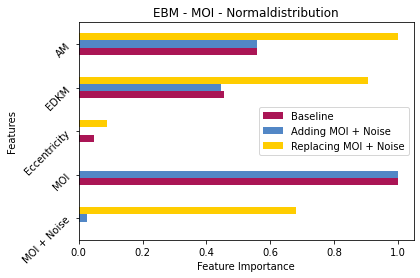

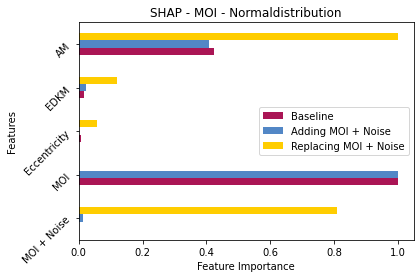

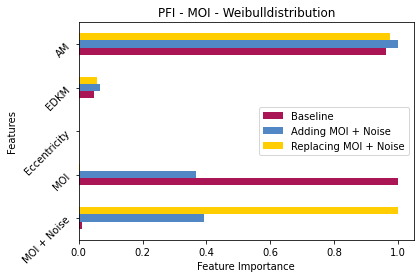

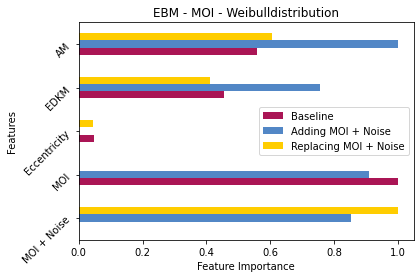

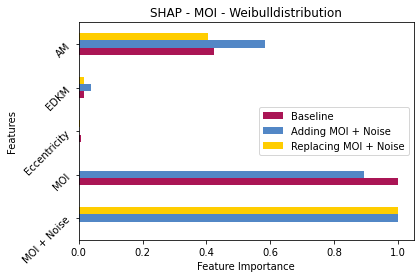

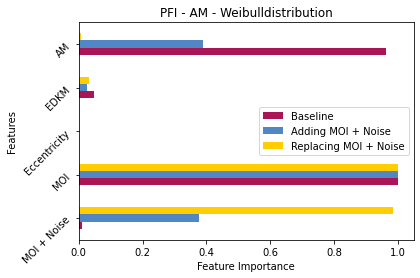

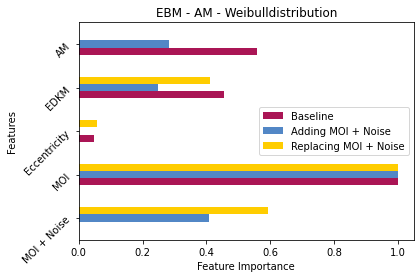

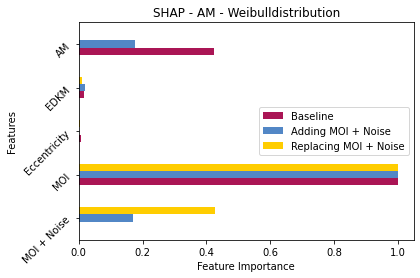

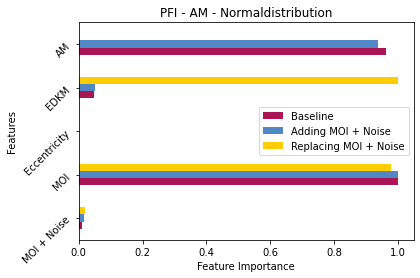

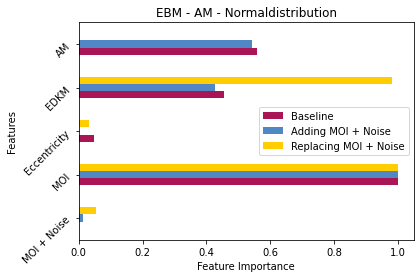

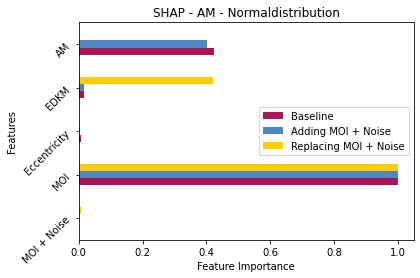

KeyError: "NormaldistributionMOI0.01isNotReplacing'"

In [216]:

importlib.reload(ph)
experiments_names = ["Baseline", "Adding MOI + Noise", "Replacing MOI + Noise"]
c = x_train.columns.tolist() + ["MOI + Noise"]
#experiments_names = [ "Baseline", "0.9", "5"]# "NormaldistributionMOI0.05isReplacing",

ph.plot_bar_per_scale(res["pfi_results"],  c,experiments=["Baseline0.01isNotReplacing",  "NormaldistributionMOI0.01isNotReplacing" , "NormaldistributionMOI0.01isReplacing"],experiments_names=experiments_names ,header="PFI - MOI - Normaldistribution")
ph.plot_bar_per_scale(res["ebm_results"],  c,experiments=["Baseline0.01isNotReplacing",  "NormaldistributionMOI0.01isNotReplacing" , "NormaldistributionMOI0.01isReplacing"],experiments_names=experiments_names ,header="EBM - MOI - Normaldistribution")
ph.plot_bar_per_scale(res["sharp_results"],  c,experiments=["Baseline0.01isNotReplacing",  "NormaldistributionMOI0.01isNotReplacing" , "NormaldistributionMOI0.01isReplacing"],experiments_names=experiments_names ,header="SHAP - MOI - Normaldistribution")



ph.plot_bar_per_scale(res["pfi_results"],  c,experiments=["Baseline0.01isNotReplacing",  "WeibulldistributionMOI0.01isNotReplacing" , "WeibulldistributionMOI0.01isReplacing"],experiments_names=experiments_names ,header="PFI - MOI - Weibulldistribution")
ph.plot_bar_per_scale(res["ebm_results"],  c,experiments=["Baseline0.01isNotReplacing",  "WeibulldistributionMOI0.01isNotReplacing" , "WeibulldistributionMOI0.01isReplacing"],experiments_names=experiments_names ,header="EBM - MOI - Weibulldistribution")
ph.plot_bar_per_scale(res["sharp_results"],  c,experiments=["Baseline0.01isNotReplacing",  "WeibulldistributionMOI0.01isNotReplacing" , "WeibulldistributionMOI0.01isReplacing"],experiments_names=experiments_names ,header="SHAP - MOI - Weibulldistribution")


ph.plot_bar_per_scale(res["pfi_results"],  c,experiments=["Baseline0.01isNotReplacing",  "WeibulldistributionAM0.01isNotReplacing" , "WeibulldistributionAM0.01isReplacing"],experiments_names=experiments_names ,header="PFI - AM - Weibulldistribution")
ph.plot_bar_per_scale(res["ebm_results"],  c,experiments=["Baseline0.01isNotReplacing",  "WeibulldistributionAM0.01isNotReplacing" , "WeibulldistributionAM0.01isReplacing"],experiments_names=experiments_names ,header="EBM - AM - Weibulldistribution")
ph.plot_bar_per_scale(res["sharp_results"],  c,experiments=["Baseline0.01isNotReplacing",  "WeibulldistributionAM0.01isNotReplacing" , "WeibulldistributionAM0.01isReplacing"],experiments_names=experiments_names ,header="SHAP - AM - Weibulldistribution")

ph.plot_bar_per_scale(res["pfi_results"],  c,experiments=["Baseline0.01isNotReplacing",  "NormaldistributionAM0.01isNotReplacing" , "NormaldistributionAM0.01isReplacing"],experiments_names=experiments_names ,header="PFI - AM - Normaldistribution")
ph.plot_bar_per_scale(res["ebm_results"],  c,experiments=["Baseline0.01isNotReplacing",  "NormaldistributionAM0.01isNotReplacing" , "NormaldistributionAM0.01isReplacing"],experiments_names=experiments_names ,header="EBM - AM - Normaldistribution")
ph.plot_bar_per_scale(res["sharp_results"],  c,experiments=["Baseline0.01isNotReplacing",  "NormaldistributionAM0.01isNotReplacing" , "NormaldistributionAM0.01isReplacing"],experiments_names=experiments_names ,header="SHAP - AM - Normaldistribution")




ph.plot_bar_per_scale(res["ebm_results"],  c,experiments=["Baseline0.01isNotReplacing",  "NormaldistributionMOI0.01isReplacing" , "NormaldistributionMOI0.01isNotReplacing'"],experiments_names=experiments_names ,header="EBM")
ph.plot_bar_per_scale(res["sharp_results"],  c,experiments=["Baseline0.01isNotReplacing",  "NormaldistributionMOI0.01isReplacing" , "NormaldistributionMOI0.01isNotReplacing'"],experiments_names=experiments_names ,header="SHAP")

ph.plot_bar_per_scale(res["pfi_results"],  c,experiments=["Normaldistribution0.01isReplacing","WeibulldistributionMOI0.01isReplacing","WeibulldistributionMOI0.9isReplacing" ],experiments_names=experiments_names ,header="PFI - Normaldistribution")


ph.plot_bar_per_scale(res["sharp_results"],  c,experiments=["Normaldistribution0.01isNotReplacing","NormaldistributionMOI0.01isReplacing", "NormaldistributionMOI0.05isReplacing", "NormaldistributionMOI1isReplacing" ],experiments_names=experiments_names ,header="PFI - Normaldistribution")

ph.plot_bar_per_scale(res["pfi_results"],  c,experiments=["Normaldistribution0.01isNotReplacing","WeibulldistributionMOI0.01isReplacing", "WeibulldistributionMOI0.01isNotReplacing" ],experiments_names=experiments_names ,header="PFI - Weilbulldistribution")

ph.plot_bar_per_scale(res["sharp_results"],  c,experiments=["Normaldistribution0.01isNotReplacing","NormaldistributionMOI0.01isReplacing", "NormaldistributionMOI0.01isNotReplacing" ], experiments_names=experiments_names , header="SHAP")

#ph.plot_bar_per_scale(res["sharp_results"], x_train.columns.tolist(),experiments=["Baseline0.01isNotReplacing", "NormaldistributionAM0.01isNotReplacing", "WeibulldistributionAM0.01isNotReplacing"],header="Not replacing PFI") #"NormaldistributionMOI", "WeibulldistributionMOI",
scale = 0.01
ph.plot_bar_per_scale(res["sharp_results"],  x_train.columns.tolist(),experiments=["Baseline0.01", "BaselineMOI0.01",  "BaselineAM0.01", ], header="Shap")
ph.plot_bar_per_scale(res["sharp_results"], x_train.columns.tolist(),experiments=["Baseline0.01", "NormaldistributionAM0.01", "WeibulldistributionAM0.01"],header="Shap") #"NormaldistributionMOI", "WeibulldistributionMOI",

ph.plot_bar_per_scale(res["pfi_results"], x_train.columns.tolist(),experiments=["Baseline0.1", "NormaldistributionAM0.1", "WeibulldistributionAM0.1"],header="PFI") #"NormaldistributionMOI", "WeibulldistributionMOI",
ph.plot_bar_per_scale(res["sharp_results"], x_train.columns.tolist(),experiments=["Baseline0.1", "NormaldistributionAM0.1", "WeibulldistributionAM0.1"],header="PFI") #"NormaldistributionMOI", "WeibulldistributionMOI",
ph.plot_bar_per_scale(res["pfi_results"], x_train.columns.tolist(),experiments=["Baseline", "Normaldistribution", "Weibulldistribution"], header="PFI")
ph.plot_bar_per_scale(res["sharp_results"], x_train.columns.tolist(),experiments=["Baseline", "Normaldistribution", "Weibulldistribution"], header="Shap")
ph.plot_bar_per_scale(res["ebm_results"], x_train.columns.tolist(),experiments=["Baseline", "Normaldistribution", "Weibulldistribution"], header="EBM")

In [ ]:
plot_bar(res["sharp_results"],  x_train.columns.tolist(),experiments=["Baseline", "Normaldistribution", "Weibulldistribution"], header="Shap")
plot_bar(res["pfi_results"], x_train.columns.tolist(),experiments=["Baseline", "Normaldistribution", "Weibulldistribution"],header="PFI")
plot_bar(res["ebm_results"], x_train.columns.tolist(),experiments=["Baseline", "Normaldistribution", "Weibulldistribution"], header="EBM")

In [ ]:

#fig, axs = plt.subplots(2,4)
importlib.reload(ph)
for split in split_column:
    for dist in distributions_names:
        if split == "":
            ph.plot_bar(sharp_results[f"{dist}{split}"], ebm_results[f"{dist}{split}"], pfi_results[f"{dist}{split}"], x_train.columns.tolist(), f"{dist}{split}")
        else:
            c = x_train.columns.tolist().copy()
            i = c.index('Random')
            
            columns = c[:i] + [f"{split} + Noise"] +c[i+1:]
            ph.plot_bar(sharp_results[f"{dist}{split}"], ebm_results[f"{dist}{split}"], pfi_results[f"{dist}{split}"],  columns, f"{dist}{split}")


NameError: name 'split_column' is not defined